In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy import integrate
from scipy import interpolate

In [2]:
path = "/Users/atalianb/Documents/data_LBSG/Blok_McGaugh_& _Rubin_(2001)/"

In [3]:
##Values
####
eps_ = 2.5e-4#
m_a_ = 1.0e-22#eV/c^2
G_kpc = 4.302e-6#kpc/SolarMass(km/s)^2
####
##Integration values
###
x0_0 = 3.#first integration
x0_0v1 = 0.01# Start of integration. Use 0.01 for continuity in l=3 solution, for 0,1,2 0.0 it's ok
xf_0v1 = 10.# End of integration
step_0 = 0.5#Step to integrate from x0_0 until xf_0v1 is reached
##l=0
u1_0 = 0.63173215# 1st trial value of unknown init. cond.
u2_0 = 1.28125868# 2nd trial value of unknown init. cond.
u_0 = np.array([u1_0, u2_0])
###l=1 
u1_1 = -3.7# 1st trial value of unknown init. cond.
u2_1 = -2.2# 2nd trial value of unknown init. cond.
u_1 = np.array([u1_1, u2_1])

In [4]:
def Integrate(func,x0,y0,x,h):
    # Finds value of y for a given x using step size h 
    # and initial value y0 at x0.
    def RK4(func,x0,y0,h):
        K0 = h*func(x0,y0)
        K1 = h*func(x0 + 0.5*h, y0 + 0.5*K0)
        K2 = h*func(x0 + 0.5*h, y0 + 0.5*K1)
        K3 = h*func(x0 + h, y0 + K2)
        return (K0 + 2.*K1 + 2.*K2 + K3)/6.
    X = []
    Y = []
    X.append(x0)
    Y.append(y0)
    while x0 < x:
         # Count number of iterations using step size or
        h = min(h,x - x0)# step height h
        y0 = y0 + RK4(func,x0,y0,h)#update next value of y
        x0 = x0 + h#update next value of x
        X.append(x0)
        Y.append(y0)
    return np.array(X),np.array(Y)

In [5]:
def shooting(func,u,x0,x,xf,step,k,h=0.01):
    def res(u):# Boundary condition residual
        X,Y = Integrate(func,x0,IC(u,k),x,h)
        y = Y[len(Y) - 1]#last value of Y
        r = np.zeros(len(u))
        r[0] = y[0]#y0(inf)=0
        r[1] = y[2]/x + y[3]#y_3(inf)/r + y_4(inf)=0
        return r
    x_list = []
    root_list = []
    while x<=xf:
        x_list.append(x)
        root = optimize.root(res,u)
        u = root.x
        root_temp = optimize.root(res,root.x)
        root_list.append(root_temp.x)
        X,Y = Integrate(func,x0,IC(root_temp.x,k),x,h)
        x = x+step
    return X,Y,root_temp,np.array(x_list),np.array(root_list)

In [6]:
def IC(u,k):#Initial conditions array, the first correspond to the initial condition in phi
    return np.array([k,0.0,u[0],0.0,u[1]])

In [7]:
def f0(x,y):
    l = 0.
    F = np.zeros(5)
    if x==0:
        F[0] = y[1]
        F[1] = 2.*y[0]*(y[2]-y[4])
        F[2] = y[3]
        F[3] = 0.
        F[4] = 0.
    else:
        F[0] = y[1]
        F[1] = -2.*(l+1.)*y[1]/x +2.*y[0]*(y[2]-y[4])
        F[2] = y[3]
        F[3] = (2.*l+1.)*x**(2.*l)*y[0]**2. - 2.*y[3]/x
        F[4] = 0.
    return F
def f1(x,y):
    l = 1.
    F = np.zeros(5)
    if x==0:
        F[0] = y[1]
        F[1] = 2.*y[0]*(y[2]-y[4])
        F[2] = y[3]
        F[3] = 0.
        F[4] = 0.
    else:
        F[0] = y[1]
        F[1] = -2.*(l+1.)*y[1]/x +2.*y[0]*(y[2]-y[4])
        F[2] = y[3]
        F[3] = (2.*l+1.)*x**(2.*l)*y[0]**2. - 2.*y[3]/x
        F[4] = 0.
    return F

In [8]:
def Mass_func(r,phi,l):
    Int = np.zeros(len(r))
    dr = np.diff(r)[0]
    phi_array = np.array(phi[:,0])
    for i in range(0,len(r)-1):
        Int[i+1] = dr*(phi_array[i+1]**2.*r[i+1]**(2.*l+2.)) + Int[i]
    return Int

In [9]:
def Vc2_cir(r,eps,M):
    units =8.95e10*eps**2.
    return (units*M)/r
####
##Units for r in kpc
###
def r_units(r,eps,m_a):
    return (6.39e-27*r)/(eps*m_a)

In [10]:
#The function integrate f0 with the shooting method,
#integrates to find the M(r) and returns the r[kpc] and Vc[km/s] 
#if the last element of r[kpc] array is minor than the last element of the r data array
#takes the last element of the M(r) array and compute the Vc^2 for the rest of the r elements
def Vc_xy_l0(r,m_a,eps,l=0.):
    X0,Y0,root0_f,arr_x0,arr_list0=shooting(f0,u_0,x0_0v1,x0_0,xf_0v1,step_0,k=1.)
    M_r0 = Mass_func(X0,Y0,l=0.)#Integrates rho(r) to obtain M(r)
    Vc2_r0 = Vc2_cir(X0,eps,M_r0)#Vc^2[km/s]^2 theoretical
    X0_units = r_units(X0,eps,m_a)#r[kpc] theoretical
    M_r0_units = M_r0*eps*1.34e-10/m_a#M(r) with Solar Mass units
    if X0_units[-1]<r[-1]:
        #array from last element of the r[kpc] theoretical to the last element of the data array,
        # with 80 elements. It can be replaced by np.arange(X0_units[-1],vecRp_data[-1],0.1) 
        #but you have to be careful in the next function with interpolate
        r_array = np.linspace(X0_units[-1],r[-1],80)
        Vc2_rmayor = G_kpc*M_r0_units[-1]/r_array#Computes Vc^2 with with the last result from M(r)
        Vc2_total = np.append(Vc2_r0,Vc2_rmayor)#creates an array of Vc^2 with Vc2_r0 and Vc2_rmayor
        r_total = np.append(X0_units,r_array)
        return r_total,np.sqrt(Vc2_total)
    else:
        return X0_units,np.sqrt(Vc2_r0)

In [48]:
def Vc_xy(r,m_a,eps,func,s_begin,l):
    X0,Y0,root0_f,arr_x0,arr_list0=shooting(func,s_begin,x0_0v1,x0_0,xf_0v1,step_0,k=1.)
    M_r0 = Mass_func(X0,Y0,l)#Integrates rho(r) to obtain M(r)
    Vc2_r0 = Vc2_cir(X0,eps,M_r0)#Vc^2[km/s]^2 theoretical
    X0_units = r_units(X0,eps,m_a)#r[kpc] theoretical
    M_r0_units = M_r0*eps*1.34e-10/m_a#M(r) with Solar Mass units
    if X0_units[-1]<r[-1]:
        #array from last element of the r[kpc] theoretical to the last element of the data array,
        # with 80 elements. It can be replaced by np.arange(X0_units[-1],vecRp_data[-1],0.1) 
        #but you have to be careful in the next function with interpolate
        r_array = np.linspace(X0_units[-1],r[-1],80)
        Vc2_rmayor = G_kpc*M_r0_units[-1]/r_array#Computes Vc^2 with with the last result from M(r)
        Vc2_total = np.append(Vc2_r0,Vc2_rmayor)#creates an array of Vc^2 with Vc2_r0 and Vc2_rmayor
        r_total = np.append(X0_units,r_array)
        return r_total,np.sqrt(Vc2_total)
    else:
        return X0_units,np.sqrt(Vc2_r0)

In [50]:
def Vc_xy_l1(r,m_a,eps,phi0,l=1.):
    X0,Y0,root0_f,arr_x0,arr_list0=shooting(f1,u_1,x0_0v1,x0_0,xf_0v1,step_0,k=phi0)
    M_r0 = Mass_func(X0,Y0,l=1.)#Integrates rho(r) to obtain M(r)
    Vc2_r0 = Vc2_cir(X0,eps,M_r0)#Vc^2[km/s]^2 theoretical
    X0_units = r_units(X0,eps,m_a)#r[kpc] theoretical
    M_r0_units = M_r0*eps*1.34e-10/m_a#M(r) with Solar Mass units
    if X0_units[-1]<r[-1]:
        r_array = np.linspace(X0_units[-1],r[-1],80)
        Vc2_rmayor = G_kpc*M_r0_units[-1]/r_array#Computes Vc^2 with with the last result from M(r)
        Vc2_total = np.append(Vc2_r0,Vc2_rmayor)#creates an array of Vc^2 with Vc2_r0 and Vc2_rmayor
        r_total = np.append(X0_units,r_array)
        return r_total,np.sqrt(Vc2_total)
    else:
        return X0_units,np.sqrt(Vc2_r0)

In [12]:
ESO3020120 = np.loadtxt(path+'ESO3020120.dat')

In [13]:
vecRp_ESO3020120 = np.array([row[1] for row in ESO3020120])# galactocentric distance [kpc]
vecvRp_ESO3020120 = np.array([row[5] for row in ESO3020120])# rotation velocity [km/s]
vecerrvRp_ESO3020120 = np.array([row[6] for row in ESO3020120])# error in rotation velocity [km/s]

Text(0.5, 0, 'r[kpc]')

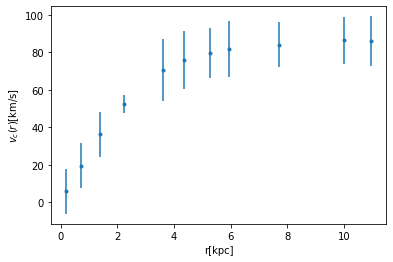

In [14]:
plt.errorbar(vecRp_ESO3020120,vecvRp_ESO3020120,yerr=vecerrvRp_ESO3020120,fmt='.')
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

In [36]:
Vc_xy_fuc = Vc_xy(vecRp_ESO3020120,m_a_,eps_,f0,u_0,l=0.)
Vc_xy_fuc_l0 = Vc_xy_l0(vecerrvRp_ESO3020120,m_a_,eps_)

0.0


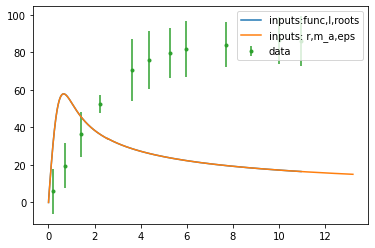

In [29]:
plt.plot(Vc_xy_fuc[0],Vc_xy_fuc[1],label='inputs:func,l,roots')
plt.plot(Vc_xy_fuc_l0[0],Vc_xy_fuc_l0[1],label='inputs: r,m_a,eps')
plt.errorbar(vecRp_ESO3020120,vecvRp_ESO3020120,yerr=vecerrvRp_ESO3020120,fmt='.',label='data')
plt.legend(loc='upper right')

In [31]:
print(Vc_xy_fuc),print(Vc_xy_fuc_l0[1]),vecRp_ESO3020120[-1]

(array([2.55600000e-03, 5.11200000e-03, 7.66800000e-03, ...,
       1.07374937e+01, 1.08437468e+01, 1.09500000e+01]), array([ 0.        ,  1.05766145,  1.55672738, ..., 16.63710482,
       16.55539429, 16.47487597]))
[ 0.          1.05766145  1.55672738 ... 15.16076174 15.08238728
 15.00521587]


(None, None, 10.95)

In [52]:
np.shape(Vc_xy_fuc),np.shape(Vc_xy_fuc_l0)

((2, 1081), (2, 1081))

In [39]:
Vc_fuc_l1 = Vc_xy(vecRp_ESO3020120,m_a_,eps_,f1,u_1,l=1.)
Vc_xy_fuc_l1 = Vc_xy_l1(vecerrvRp_ESO3020120,m_a_,eps_)

1.0


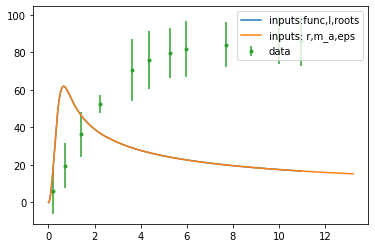

In [40]:
plt.plot(Vc_fuc_l1[0],Vc_fuc_l1[1],label='inputs:func,l,roots')
plt.plot(Vc_xy_fuc_l1[0],Vc_xy_fuc_l1[1],label='inputs: r,m_a,eps')
plt.errorbar(vecRp_ESO3020120,vecvRp_ESO3020120,yerr=vecerrvRp_ESO3020120,fmt='.',label='data')
plt.legend(loc='upper right')

In [41]:
def Vc_xi2(r,m_a,eps,func,u_begin,l):
    Vc = Vc_xy(r,m_a,eps,func,u_begin,l)
    #If you want to use np.arange in the previous function, It is recommended to use extrapolate
    f = interpolate.interp1d(Vc[0],Vc[1],fill_value='extrapolate')
    Vc_new = f(r)
    return Vc_new

# $\chi^{2}$

In [42]:
def Vc_l0_m_a_eps(r,params):
    m_a,eps = params
    Vc2 = Vc_xi2(r,m_a,eps,f0,u_0,l=0.) + Vc_xi2(r,m_a,eps,f1,u_1,l=1.)
    return np.sqrt(Vc2)

In [43]:
def Xi2_m_a_eps_ESO3020120(params):
    m_a,eps = params
    par = np.exp(m_a),np.exp(eps)
    model = Vc_l0_m_a_eps(vecRp_ESO3020120,par)
    xi  = np.sum((vecvRp_ESO3020120-model)**2./(vecerrvRp_ESO3020120)**2.)
    return xi

In [44]:
x0_m_a_eps_ESO3020120 = np.array([np.log(1.0e-23),np.log(1.0e-4)])
LS_m_a_eps_ESO3020120 = optimize.minimize(Xi2_m_a_eps_ESO3020120,x0_m_a_eps_ESO3020120,method='L-BFGS-B',bounds=((np.log(1.0e-24),np.log(1.0e-20)),(np.log(1.0e-5),np.log(1.)),))
print(LS_m_a_eps_ESO3020120)

0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
      fun: 52.24614515128648
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([3.98131621e+01, 9.02389280e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 75
      nit: 14
     njev: 25
   status: 0
  success: True
        x: array([-55.26204223,  -5.00993707])


In [45]:
print(np.exp(LS_m_a_eps_ESO3020120.x))

[1.0000000e-24 6.6713231e-03]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  This is separate from the ipykernel package so we can avoid doing imports until


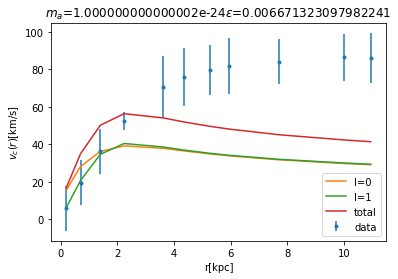

In [49]:
plt.errorbar(vecRp_ESO3020120,vecvRp_ESO3020120,yerr=vecerrvRp_ESO3020120,fmt='.',label='data')
plt.plot(vecRp_ESO3020120,np.sqrt(Vc_xi2(vecRp_ESO3020120,np.asscalar(np.exp(LS_m_a_eps_ESO3020120.x[0])),np.asscalar(np.exp(LS_m_a_eps_ESO3020120.x[1])),f0,u_0,l=0.)),label='l=0')
plt.plot(vecRp_ESO3020120,np.sqrt(Vc_xi2(vecRp_ESO3020120,np.asscalar(np.exp(LS_m_a_eps_ESO3020120.x[0])),np.asscalar(np.exp(LS_m_a_eps_ESO3020120.x[1])),f1,u_1,l=1.)),label='l=1')
plt.plot(vecRp_ESO3020120,Vc_l0_m_a_eps(vecRp_ESO3020120,np.exp(LS_m_a_eps_ESO3020120.x)),label='total')
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")
plt.title(r'$m_{a}$='+str(np.exp(LS_m_a_eps_ESO3020120.x[0]))+r'$\epsilon$='+str(np.exp(LS_m_a_eps_ESO3020120.x[1])))
plt.legend(loc='lower right')

# with $\phi_{0,\ell = 1}$ as a free parameter

In [76]:
def rescaling(phi_0,l):
    lmbd = (1./phi_0)**(1/(l+2.))
    return lmbd

In [82]:
def Vc_xy_phi(r,m_a,eps,phi0,func,s_begin,l):
    X0,Y0,root0_f,arr_x0,arr_list0=shooting(func,s_begin,x0_0v1,x0_0,xf_0v1,step_0,k=phi0)
    Xl = X0*rescaling(phi0,l)
    M_r0 = Mass_func(Xl,Y0*phi0,l)#Integrates rho(r) to obtain M(r)
    Vc2_r0 = Vc2_cir(Xl,eps,M_r0)#Vc^2[km/s]^2 theoretical
    X0_units = r_units(Xl,eps,m_a)#r[kpc] theoretical
    M_r0_units = M_r0*eps*1.34e-10/m_a#M(r) with Solar Mass units
    if X0_units[-1]<r[-1]:
        #array from last element of the r[kpc] theoretical to the last element of the data array,
        # with 80 elements. It can be replaced by np.arange(X0_units[-1],vecRp_data[-1],0.1) 
        #but you have to be careful in the next function with interpolate
        r_array = np.linspace(X0_units[-1],r[-1],80)
        Vc2_rmayor = G_kpc*M_r0_units[-1]/r_array#Computes Vc^2 with with the last result from M(r)
        Vc2_total = np.append(Vc2_r0,Vc2_rmayor)#creates an array of Vc^2 with Vc2_r0 and Vc2_rmayor
        r_total = np.append(X0_units,r_array)
        return r_total,np.sqrt(Vc2_total)
    else:
        return X0_units,np.sqrt(Vc2_r0)

In [83]:
def Vc_xi2_phi(r,m_a,eps,phi0,func,u_begin,l):
    Vc = Vc_xy_phi(r,m_a,eps,phi0,func,u_begin,l)
    #If you want to use np.arange in the previous function, It is recommended to use extrapolate
    f = interpolate.interp1d(Vc[0],Vc[1],fill_value='extrapolate')
    Vc_new = f(r)
    return Vc_new

In [84]:
def Vc_m_a_eps_phi0(r,params):
    m_a,eps,phi0 = params
    Vc2 = Vc_xi2_phi(r,m_a,eps,1.,f0,u_0,l=0.) + Vc_xi2_phi(r,m_a,eps,phi0,f1,u_1,l=1.)
    return np.sqrt(Vc2)

In [85]:
def Xi2_m_a_eps_phi0_ESO3020120(params):
    m_a,eps,phi0 = params
    par = np.exp(m_a),np.exp(eps),np.exp(phi0)
    model = Vc_m_a_eps_phi0(vecRp_ESO3020120,par)
    xi  = np.sum((vecvRp_ESO3020120-model)**2./(vecerrvRp_ESO3020120)**2.)
    return xi

In [86]:
x0_m_a_eps_phi0_ESO3020120 = np.array([np.log(1.0e-23),np.log(1.0e-4),np.log(1.0e-2)])
LS_m_a_eps_phi0_ESO3020120 = optimize.minimize(Xi2_m_a_eps_phi0_ESO3020120,x0_m_a_eps_phi0_ESO3020120,method='L-BFGS-B',bounds=((np.log(1.0e-24),np.log(1.0e-20)),(np.log(1.0e-5),np.log(1.)),(np.log(1.0e-3),np.log(1.)),))
print(LS_m_a_eps_phi0_ESO3020120)

      fun: 52.246145149825566
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.98130015e+01,  4.70379294e-04, -2.51120014e-01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 168
      nit: 27
     njev: 42
   status: 0
  success: True
        x: array([-55.26204223,  -5.0099392 ,   0.        ])


In [87]:
print(np.exp(LS_m_a_eps_phi0_ESO3020120.x))

[1.00000000e-24 6.67130888e-03 1.00000000e+00]


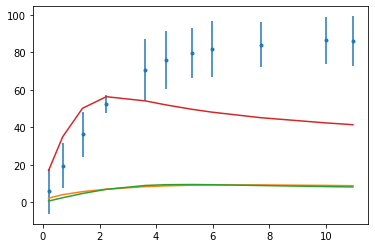

In [93]:
plt.errorbar(vecRp_ESO3020120,vecvRp_ESO3020120,yerr=vecerrvRp_ESO3020120,fmt='.',label='data')
plt.plot(vecRp_ESO3020120,np.sqrt(Vc_xi2(vecRp_ESO3020120,6.2e-24,3.8e-4,f0,u_0,l=0.)),label='l=0')
plt.plot(vecRp_ESO3020120,np.sqrt(Vc_xi2(vecRp_ESO3020120,8.8e-24,3.7e-4,f1,u_1,l=1.)),label='l=1')
plt.plot(vecRp_ESO3020120,Vc_m_a_eps_phi0(vecRp_ESO3020120,np.exp(LS_m_a_eps_phi0_ESO3020120.x)),label='total')

/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  This is separate from the ipykernel package so we can avoid doing imports until


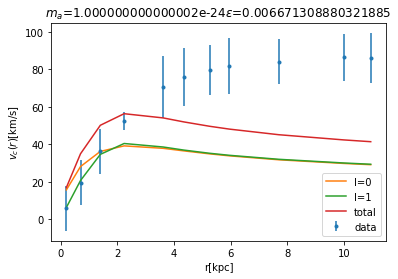

In [88]:
plt.errorbar(vecRp_ESO3020120,vecvRp_ESO3020120,yerr=vecerrvRp_ESO3020120,fmt='.',label='data')
plt.plot(vecRp_ESO3020120,np.sqrt(Vc_xi2(vecRp_ESO3020120,np.asscalar(np.exp(LS_m_a_eps_phi0_ESO3020120.x[0])),np.asscalar(np.exp(LS_m_a_eps_phi0_ESO3020120.x[1])),f0,u_0,l=0.)),label='l=0')
plt.plot(vecRp_ESO3020120,np.sqrt(Vc_xi2(vecRp_ESO3020120,np.asscalar(np.exp(LS_m_a_eps_phi0_ESO3020120.x[0])),np.asscalar(np.exp(LS_m_a_eps_phi0_ESO3020120.x[1])),f1,u_1,l=1.)),label='l=1')
plt.plot(vecRp_ESO3020120,Vc_m_a_eps_phi0(vecRp_ESO3020120,np.exp(LS_m_a_eps_phi0_ESO3020120.x)),label='total')
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")
plt.title(r'$m_{a}$='+str(np.exp(LS_m_a_eps_phi0_ESO3020120.x[0]))+r'$\epsilon$='+str(np.exp(LS_m_a_eps_phi0_ESO3020120.x[1])))
plt.legend(loc='lower right')

## Método TNC

In [89]:
x0_m_a_eps_phi0_ESO3020120 = np.array([np.log(1.0e-23),np.log(1.0e-4),np.log(1.0e-2)])
LS_m_a_eps_phi0_ESO3020120 = optimize.minimize(Xi2_m_a_eps_phi0_ESO3020120,x0_m_a_eps_phi0_ESO3020120,method='TNC',bounds=((np.log(1.0e-24),np.log(1.0e-20)),(np.log(1.0e-5),np.log(1.)),(np.log(1.0e-3),np.log(1.)),))
print(LS_m_a_eps_phi0_ESO3020120)

     fun: 52.24614514931129
     jac: array([ 3.98128651e+01,  1.08002496e-04, -2.51229437e-01])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 360
     nit: 17
  status: 1
 success: True
       x: array([-55.26204223,  -5.00994099,   0.        ])


In [90]:
print(np.exp(LS_m_a_eps_phi0_ESO3020120.x))

[1.00000000e-24 6.67129696e-03 1.00000000e+00]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  This is separate from the ipykernel package so we can avoid doing imports until


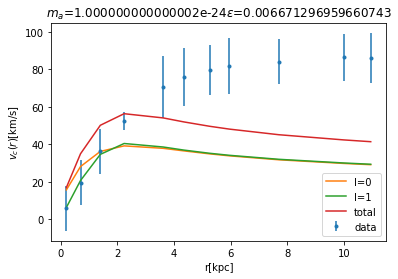

In [91]:
plt.errorbar(vecRp_ESO3020120,vecvRp_ESO3020120,yerr=vecerrvRp_ESO3020120,fmt='.',label='data')
plt.plot(vecRp_ESO3020120,np.sqrt(Vc_xi2(vecRp_ESO3020120,np.asscalar(np.exp(LS_m_a_eps_phi0_ESO3020120.x[0])),np.asscalar(np.exp(LS_m_a_eps_phi0_ESO3020120.x[1])),f0,u_0,l=0.)),label='l=0')
plt.plot(vecRp_ESO3020120,np.sqrt(Vc_xi2(vecRp_ESO3020120,np.asscalar(np.exp(LS_m_a_eps_phi0_ESO3020120.x[0])),np.asscalar(np.exp(LS_m_a_eps_phi0_ESO3020120.x[1])),f1,u_1,l=1.)),label='l=1')
plt.plot(vecRp_ESO3020120,Vc_m_a_eps_phi0(vecRp_ESO3020120,np.exp(LS_m_a_eps_phi0_ESO3020120.x)),label='total')
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")
plt.title(r'$m_{a}$='+str(np.exp(LS_m_a_eps_phi0_ESO3020120.x[0]))+r'$\epsilon$='+str(np.exp(LS_m_a_eps_phi0_ESO3020120.x[1])))
plt.legend(loc='lower right')